In [9]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.linear_model import lars_path
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, SGDClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics

import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

from imblearn.over_sampling import RandomOverSampler
from collections import Counter, defaultdict

import pandas_profiling

from sklearn.svm import LinearSVC, SVC

from scipy.spatial import distance
from scipy.cluster import hierarchy

from bokeh.plotting import figure, show, output_file
from bokeh.embed import components
from bokeh.models import CategoricalColorMapper, HoverTool

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import copy
import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [10]:
try:
    conn = sqlite3.connect('database.sqlite')
except Error as e:
    print(e)

In [11]:
cur = conn.cursor()

In [12]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';");

In [13]:
rows = cur.fetchall()
 
for row in rows:
    print(row)

('primary_results',)
('county_facts',)
('county_facts_dictionary',)


In [14]:
cur.execute("SELECT * FROM county_facts_dictionary;")
rows = cur.fetchall()
for row in rows:
    print(row)

('PST045214', 'Population, 2014 estimate')
('PST040210', 'Population, 2010 (April 1) estimates base')
('PST120214', 'Population, percent change - April 1, 2010 to July 1, 2014')
('POP010210', 'Population, 2010')
('AGE135214', 'Persons under 5 years, percent, 2014')
('AGE295214', 'Persons under 18 years, percent, 2014')
('AGE775214', 'Persons 65 years and over, percent, 2014')
('SEX255214', 'Female persons, percent, 2014')
('RHI125214', 'White alone, percent, 2014')
('RHI225214', 'Black or African American alone, percent, 2014')
('RHI325214', 'American Indian and Alaska Native alone, percent, 2014')
('RHI425214', 'Asian alone, percent, 2014')
('RHI525214', 'Native Hawaiian and Other Pacific Islander alone, percent, 2014')
('RHI625214', 'Two or More Races, percent, 2014')
('RHI725214', 'Hispanic or Latino, percent, 2014')
('RHI825214', 'White alone, not Hispanic or Latino, percent, 2014')
('POP715213', 'Living in same house 1 year & over, percent, 2009-2013')
('POP645213', 'Foreign born 

In [15]:
gen_2016_df = pd.read_csv('2016_US_County_Level_Presidential_Results.csv')

In [16]:
gen_2016_df.head()

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,0,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2013
1,1,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2016
2,2,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2020
3,3,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2050
4,4,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2060


In [17]:
gen_2016_df['per_point_diff'] = gen_2016_df['per_point_diff'].astype(str)
gen_2016_df['per_point_diff'] = gen_2016_df['per_point_diff'].str.replace('%', '')
gen_2016_df['per_point_diff'] = gen_2016_df['per_point_diff'].astype(float)

In [18]:
gen_2016_df['diff'] = gen_2016_df['diff'].astype(str)
gen_2016_df['diff'] = gen_2016_df['diff'].str.replace(',', '')
gen_2016_df['diff'] = gen_2016_df['diff'].astype(float)

In [19]:
#pandas_profiling.ProfileReport(gen_2016_df)

In [20]:
gen_2016_df.head()

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,0,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2013
1,1,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2016
2,2,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2020
3,3,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2050
4,4,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2060


In [21]:
gen_2016_df.describe()

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,combined_fips
count,3141.000000,3.141000e+03,3141.000000,3.141000e+03,3141.000000,3141.000000,3.141000e+03,3141.000000,3141.000000
mean,1570.000000,2.073410e+04,20645.278574,4.363662e+04,0.317637,0.635144,1.187643e+04,39.010847,30388.584527
std,906.872924,7.200370e+04,41627.228433,1.145680e+05,0.152983,0.156130,4.260681e+04,20.824405,15162.375610
min,0.000000,4.000000e+00,57.000000,6.400000e+01,0.031447,0.041221,2.000000e+00,0.040000,1001.000000
25%,785.000000,1.175000e+03,3241.000000,4.870000e+03,0.205370,0.545760,1.608000e+03,21.820000,18179.000000
50%,1570.000000,3.194000e+03,7268.000000,1.114400e+04,0.286400,0.665353,3.797000e+03,40.050000,29177.000000
75%,2355.000000,1.004700e+04,18130.000000,2.979900e+04,0.398241,0.750265,8.815000e+03,55.360000,45081.000000
max,3140.000000,1.893770e+06,620285.000000,2.652072e+06,0.928466,0.952727,1.273485e+06,91.640000,56045.000000


In [22]:
counties_df = pd.read_sql("SELECT * FROM county_facts", conn)

In [23]:
counties_df.to_csv('counties.csv')

In [15]:
pandas_profiling.ProfileReport(counties_df)

Number of variables,54
Number of observations,3195
Total Missing (%),0.0%
Total size in memory,1.3 MiB
Average record size in memory,432.0 B
Numeric,37
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,15


In [16]:
counties_df.head()

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,0,United States,,318857056,308758105,3.3,308745538,6.2,23.1,14.5,...,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,Alabama,,4849377,4780127,1.4,4779736,6.1,22.8,15.3,...,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
2,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,1005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0


In [17]:
counties_df.describe()

,fips,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
count,3195.000000,3.195000e+03,3.195000e+03,3195.000000,3.195000e+03,3195.000000,3195.000000,3195.000000,3195.000000,3195.000000,...,3195.000000,3195.000000,3.195000e+03,3.195000e+03,3.195000e+03,3195.000000,3.195000e+03,3.195000e+03,3.195000e+03,3195.000000
mean,30358.079499,2.993963e+05,2.899137e+05,0.508545,2.899019e+05,5.900782,22.545290,17.524632,49.913271,84.953271,...,1.735055,18.108169,4.732329e+06,3.804132e+06,3.677504e+06,10287.325196,5.739886e+05,9.823005e+02,3.316344e+03,261.265227
std,15181.225584,5.768468e+06,5.584181e+06,4.180066,5.583955e+06,1.211925,3.418896,4.433712,2.425066,16.290780,...,6.222794,12.809596,9.623516e+07,7.613666e+07,7.082882e+07,5409.442797,1.112830e+07,1.902455e+04,6.402903e+04,1718.802670
min,0.000000,0.000000e+00,0.000000e+00,-17.000000,8.200000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.000000e+00,0.000000
25%,18172.000000,1.113450e+04,1.129500e+04,-1.900000,1.129500e+04,5.200000,20.500000,14.700000,49.500000,80.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,7.818500e+04,6910.000000,6.240000e+03,6.000000e+00,4.325450e+02,17.150000
50%,29175.000000,2.655300e+04,2.644600e+04,-0.100000,2.642400e+04,5.800000,22.500000,17.200000,50.400000,91.900000,...,0.000000,23.400000,7.103000e+04,4.852600e+04,2.604220e+05,9806.000000,2.606300e+04,3.400000e+01,6.232800e+02,45.700000
75%,45076.000000,7.247600e+04,7.150450e+04,2.300000,7.144800e+04,6.500000,24.200000,19.800000,51.100000,95.900000,...,0.600000,27.800000,9.766630e+05,2.677625e+05,8.358655e+05,13002.500000,1.037800e+05,1.655000e+02,9.445850e+02,115.800000
max,56045.000000,3.188571e+08,3.087581e+08,72.900000,3.087455e+08,13.700000,42.000000,52.900000,56.800000,99.300000,...,78.000000,56.200000,5.319456e+09,4.174287e+09,3.917663e+09,80800.000000,6.137957e+08,1.046363e+06,3.531905e+06,69467.500000


In [18]:
gen_2016_df['dem_win'] = np.where(gen_2016_df['votes_gop'] < gen_2016_df['votes_dem'], 1, 0)

In [19]:
gen_2016_df.head()

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips,dem_win
0,0,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2013,0
1,1,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2016,0
2,2,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2020,0
3,3,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2050,0
4,4,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,2060,0


In [20]:
gen_2016_counties = gen_2016_df.set_index('combined_fips').join(counties_df.set_index('fips'), how='inner')

In [21]:
gen_2016_rep = gen_2016_counties.loc[gen_2016_counties['dem_win'] == 0]
gen_2016_dem = gen_2016_counties.loc[gen_2016_counties['dem_win'] == 1]

In [22]:
gen_2016_counties.shape

(3141, 64)

In [23]:
gen_2016_rep['SBO515207'].value_counts()

0.0    2642
0.1       4
0.4       4
0.2       3
0.3       1
Name: SBO515207, dtype: int64

In [24]:
gen_2016_dem['SBO515207'].value_counts()

0.0     436
0.1      27
0.3      10
0.2       7
9.1       2
0.4       2
10.2      1
10.5      1
0.5       1
Name: SBO515207, dtype: int64

In [25]:
gen_2016_counties.head()

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
2013,0,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,...,0.0,0.0,0,0,9326,3309,0,0,6981.94,0.4
2016,1,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,...,0.0,26.3,634809,62073,46785,9823,14684,2,4390.28,1.3
2020,2,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,...,3.1,30.2,0,2914025,4482714,16096,933301,770,1704.68,171.2
2050,3,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,...,0.0,20.8,0,3454,96755,5658,4091,11,40570.00,0.4
2060,4,93003.0,130413.0,246588.0,0.377159,0.52887,37410.0,15.17,AK,Alaska,...,0.0,0.0,0,0,12785,12823,13278,2,503.84,2.0


In [26]:
column_list = gen_2016_counties.columns.tolist()
census_columns = column_list[column_list.index('PST045214'):]

In [27]:
column_to_index = {}
for index, col in enumerate(census_columns):
    column_to_index[col] = index

In [28]:
index_to_column = {}
for index, col in enumerate(census_columns):
    index_to_column[index] = col

In [29]:
def col_list_to_index_list(columns):
    index_list = []
    for col in columns:
        index_list.append(column_to_index[col])
        
    return index_list

In [30]:
def index_list_to_col_list(indices):
    column_list = []
    for index in indices:
        column_list.append(index_to_column[index])
        
    return column_list

In [31]:
census_columns

['PST045214',
 'PST040210',
 'PST120214',
 'POP010210',
 'AGE135214',
 'AGE295214',
 'AGE775214',
 'SEX255214',
 'RHI125214',
 'RHI225214',
 'RHI325214',
 'RHI425214',
 'RHI525214',
 'RHI625214',
 'RHI725214',
 'RHI825214',
 'POP715213',
 'POP645213',
 'POP815213',
 'EDU635213',
 'EDU685213',
 'VET605213',
 'LFE305213',
 'HSG010214',
 'HSG445213',
 'HSG096213',
 'HSG495213',
 'HSD410213',
 'HSD310213',
 'INC910213',
 'INC110213',
 'PVY020213',
 'BZA010213',
 'BZA110213',
 'BZA115213',
 'NES010213',
 'SBO001207',
 'SBO315207',
 'SBO115207',
 'SBO215207',
 'SBO515207',
 'SBO415207',
 'SBO015207',
 'MAN450207',
 'WTN220207',
 'RTN130207',
 'RTN131207',
 'AFN120207',
 'BPS030214',
 'LND110210',
 'POP060210']

In [32]:
#  first split off test subset, then over-sample, then scale resampled ... and can scale test also with same scaling

X, y = gen_2016_counties.drop('dem_win',axis=1), gen_2016_counties['dem_win']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X[census_columns],y)

ss = StandardScaler()

ss.fit(X_resampled)
X_resampled = ss.transform(X_resampled)
X_test = ss.transform(X_test[census_columns])


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [33]:
ss

StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
gen_2016_counties['dem_win'].value_counts()

0    2654
1     487
Name: dem_win, dtype: int64

In [35]:
gen_2016_counties['dem_win'].value_counts(normalize=True)

0    0.844954
1    0.155046
Name: dem_win, dtype: float64

In [36]:
cur.execute("SELECT * FROM county_facts_dictionary;")
rows = cur.fetchall()
census_desc_list = []
census_cols_list = []
for row in rows:
    census_desc_list.append(row)
    census_cols_list.append(row[0])

In [37]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(model, 1)
fit = rfe.fit(X_resampled, y_resampled)
print(f'Num Features: {fit.n_features_}')

feature_list = []
feature_cols = []
for index, item in enumerate(fit.ranking_):
    if item == 1:
        print(census_desc_list[index])
        feature_cols.append(index)
        
y_pred = rfe.estimator_.predict(X_test[:,feature_cols])
y_pred_prob = rfe.estimator_.predict_proba(X_test[:,feature_cols])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1])) 


Num Features: 1
('RHI825214', 'White alone, not Hispanic or Latino, percent, 2014')
Accuracy: 0.7440381558028617
F1: 0.45051194539249145
auc:  0.8024302430243024


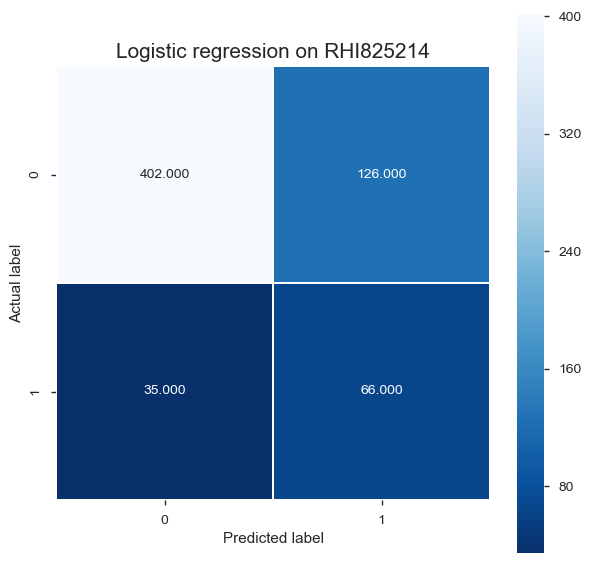

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic regression on RHI825214'
plt.title(all_sample_title, size = 15);

In [39]:
# prediction_hard = y_pred

# feature = X_test[feature_cols[0]]

# dem_mask = (y_test == 1).values

# plt.figure(figsize=(7,7))
# plt.xscale('log')
# plt.plot(feature[dem_mask], prediction_hard[dem_mask] + 0.1, 'bo', label='Actually dem', alpha=0.1)
# plt.plot(feature[~dem_mask], prediction_hard[~dem_mask], 'ro', label='Actually repub', alpha=0.1)
# plt.ylim(-0.05, 1.05)
# plt.xlabel('PST045214')
# plt.ylabel('Prediction (1=repub)')
# plt.title('Logistic regression prediction for dem vs repub on population')
# plt.legend(loc='upper right');

In [40]:
# A benchmark for a large logistic regression model, relatively difficult to interpret
model = LogisticRegression(solver='lbfgs',  max_iter=1000)
rfe = RFECV(model, cv=5)
fit = rfe.fit(X_resampled, y_resampled)
print(f'Num Features: {fit.n_features_}')
print(f'Feature Ranking: {fit.ranking_}')

feature_list = []
feature_cols = []
for index, item in enumerate(fit.ranking_):
    if item == 1:
        feature_cols.append(index)
        
y_pred = rfe.estimator_.predict(X_test[:,feature_cols])
y_pred_prob = rfe.estimator_.predict_proba(X_test[:,feature_cols])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1])) 
 

Num Features: 46
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 4 1 1
 6 5 1 1 2 1 1 1 1 1 1 1 1 1]
Accuracy: 0.9093799682034976
F1: 0.7634854771784233
auc:  0.966959195919592


In [41]:
#clf = RandomForestClassifier(n_estimators=100, max_depth=2)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))


Accuracy: 0.9348171701112877
F1: 0.7853403141361257


In [42]:
cur.execute("SELECT * FROM county_facts_dictionary;")
rows = cur.fetchall()
census_desc_list = []
for row in rows:
    census_desc_list.append(row)

In [43]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=60)
clf = clf.fit(X_resampled,y_resampled)

In [44]:
y_pred = clf.predict(X_test)

In [45]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8728139904610492


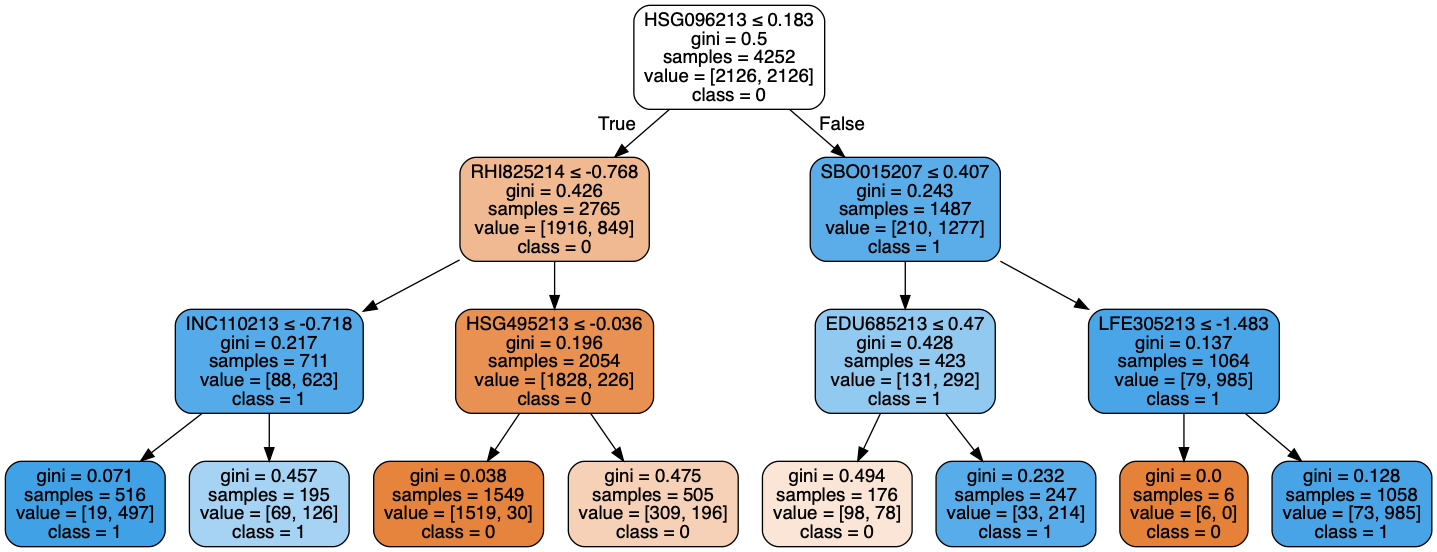

In [46]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = census_columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('elections_tree.png')
Image(graph.create_png())

In [47]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)

rfe = RFE(model, 5)
fit = rfe.fit(X_resampled, y_resampled)
print(f'Num Features: {fit.n_features_}')

feature_names = []
feature_cols = []
top_five_name_to_col = {}
for index, item in enumerate(fit.ranking_):
    if item == 1:
        print(census_desc_list[index])
        feature_cols.append(index)
        feature_names.append(census_columns[index])
        top_five_name_to_col[census_columns[index]] = index
        
y_pred = rfe.estimator_.predict(X_test[:,feature_cols])
y_pred_prob = rfe.estimator_.predict_proba(X_test[:,feature_cols])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1])) 


Num Features: 5
('RHI825214', 'White alone, not Hispanic or Latino, percent, 2014')
('EDU685213', "Bachelor's degree or higher, percent of persons age 25+, 2009-2013")
('HSG495213', 'Median value of owner-occupied housing units, 2009-2013')
('HSD410213', 'Households, 2009-2013')
('INC110213', 'Median household income, 2009-2013')
Accuracy: 0.8775834658187599
F1: 0.6980392156862745
auc:  0.9458445844584458


In [48]:
pickle_lr_file = open("./pickled/top_five_lr.pickle", "wb")
pickle.dump(rfe.estimator_, pickle_lr_file)
pickle_lr_file.close()

pickle_name_to_col_file = open("./pickled/top_five_name_to_col.pickle", "wb")
pickle.dump(top_five_name_to_col, pickle_name_to_col_file)
pickle_name_to_col_file.close()

pickle_feature_cols_file = open("./pickled/top_five_feature_indices.pickle", "wb")
pickle.dump(feature_cols, pickle_feature_cols_file)
pickle_feature_cols_file.close()

print(top_five_name_to_col)
print(feature_cols)

{'RHI825214': 15, 'EDU685213': 20, 'HSG495213': 26, 'HSD410213': 27, 'INC110213': 30}
[15, 20, 26, 27, 30]


In [49]:
pickle_ss_file = open("./pickled/scaler.pickle", "wb")
pickle.dump(ss, pickle_ss_file)
pickle_ss_file.close()


In [50]:
pickle_col_to_index_file = open("./pickled/col_to_index.pickle", "wb")
pickle.dump(column_to_index, pickle_col_to_index_file)
pickle_col_to_index_file.close()


In [51]:
pickle_index_to_col_file = open("./pickled/index_to_col.pickle", "wb")
pickle.dump(index_to_column, pickle_index_to_col_file)
pickle_index_to_col_file.close()


In [52]:
for feature in feature_names:
    print(np.median(counties_df[feature]))

84.2
17.7
109800.0
10050.0
44301.0


In [53]:
x_filled = np.zeros((1, len(index_to_column)))

In [54]:
pickle_census_desc_list_file = open("./pickled/census_desc_list.pickle", "wb")
pickle.dump(census_desc_list, pickle_census_desc_list_file)
pickle_census_desc_list_file.close()


In [55]:
#predict at 0,0,0,0,0 ....
np.array([0,0,0,0,0]).reshape(1,-1)
prediction = rfe.estimator_.predict(np.array([0,0,0,0,0]).reshape(1,-1))
print(prediction)

[1]


In [56]:
np.array([0,0,0,0,0]).reshape(1,-1)
prediction = rfe.estimator_.predict_proba(np.array([0,0,0,0,0]).reshape(1,-1))
print(prediction)

[[0.40898634 0.59101366]]


In [57]:
type(prediction)

numpy.ndarray

In [58]:
top_five_features_names =  copy.deepcopy(feature_names)

In [59]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)

rfe = RFE(model, 10)
fit = rfe.fit(X_resampled, y_resampled)
print(f'Num Features: {fit.n_features_}')

feature_names = []
feature_cols = []
for index, item in enumerate(fit.ranking_):
    if item == 1:
        print(census_desc_list[index])
        feature_cols.append(index)
        feature_names.append(census_columns[index])
        
y_pred = rfe.estimator_.predict(X_test[:,feature_cols])
y_pred_prob = rfe.estimator_.predict_proba(X_test[:,feature_cols])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1])) 

Num Features: 10
('RHI525214', 'Native Hawaiian and Other Pacific Islander alone, percent, 2014')
('RHI825214', 'White alone, not Hispanic or Latino, percent, 2014')
('POP715213', 'Living in same house 1 year & over, percent, 2009-2013')
('EDU685213', "Bachelor's degree or higher, percent of persons age 25+, 2009-2013")
('HSG096213', 'Housing units in multi-unit structures, percent, 2009-2013')
('HSG495213', 'Median value of owner-occupied housing units, 2009-2013')
('HSD410213', 'Households, 2009-2013')
('INC110213', 'Median household income, 2009-2013')
('NES010213', 'Nonemployer establishments, 2013')
('SBO515207', 'Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007')
Accuracy: 0.8712241653418124
F1: 0.6823529411764706
auc:  0.948094809480948


In [60]:
top_ten_features_names =  copy.deepcopy(feature_names)

In [61]:
# poor results
# model = SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3)

# rfe = RFE(model, 5)
# fit = rfe.fit(X_resampled, y_resampled)
# print(f'Num Features: {fit.n_features_}')

# feature_list = []
# feature_cols = []
# for index, item in enumerate(fit.ranking_):
#     if item == 1:
#         print(census_desc_list[index])
#         feature_cols.append(index)
        
# y_pred = rfe.estimator_.predict(X_test[:,feature_cols])
# y_pred_prob = rfe.estimator_.predict_proba(X_test[:,feature_cols])
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("F1:",metrics.f1_score(y_test, y_pred))
# print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1])) 


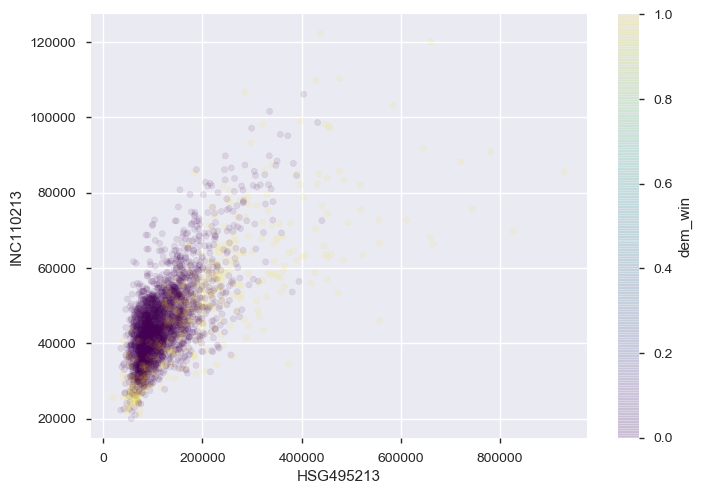

In [62]:
gen_2016_counties.plot.scatter(x='HSG495213', y='INC110213', c='dem_win', cmap='viridis', alpha=0.1);

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



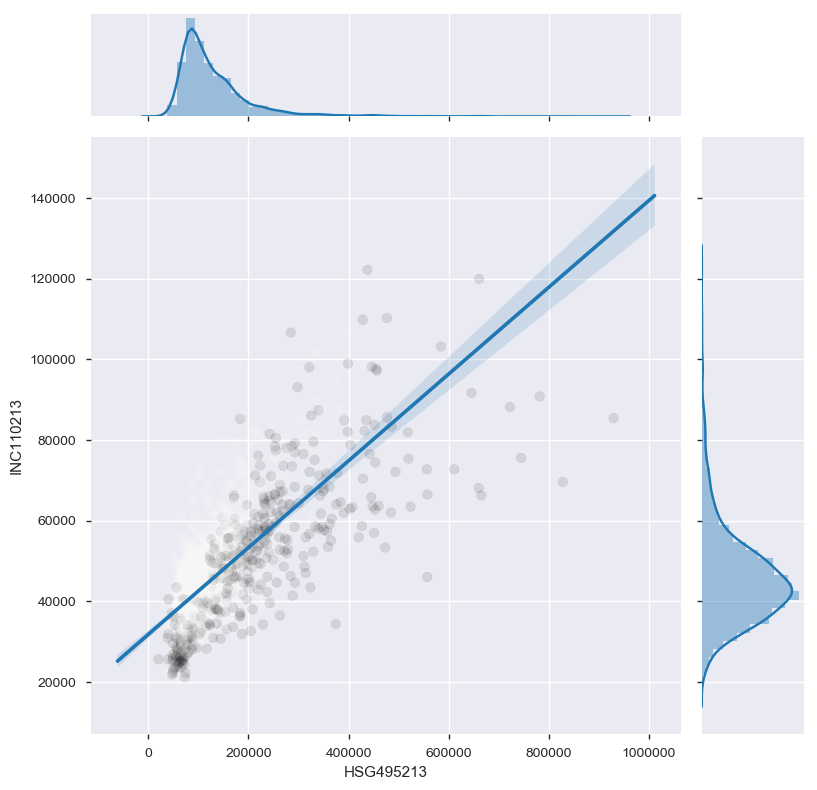

In [63]:
g = sns.jointplot(x='HSG495213', y='INC110213', data=gen_2016_counties, height=8, kind = 'reg', scatter = False);
g.ax_joint.scatter(x='HSG495213', y='INC110213', c='dem_win', data=gen_2016_counties, alpha=0.1);

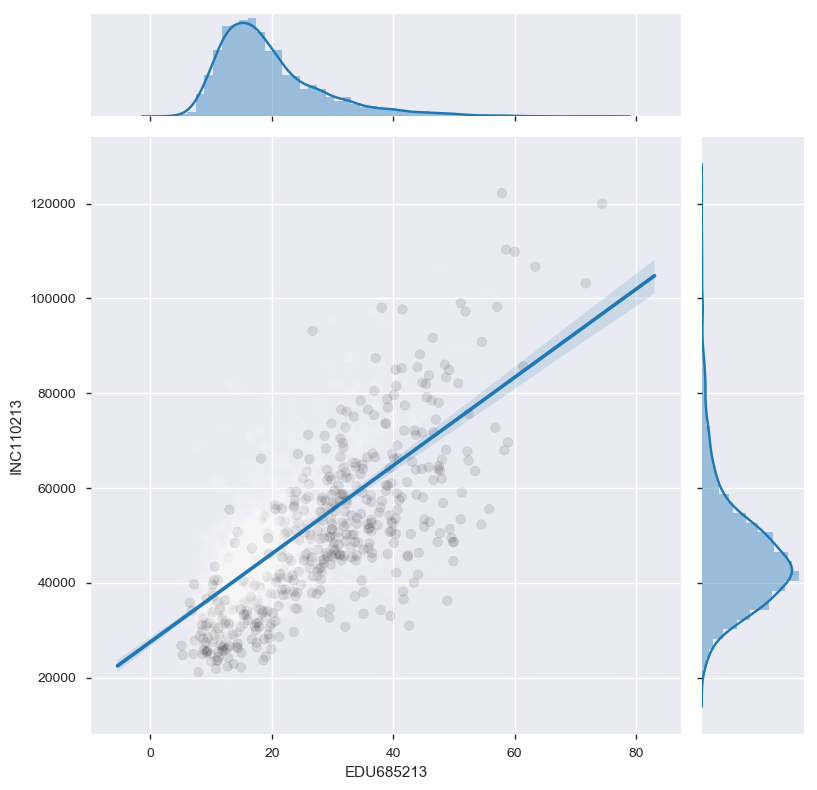

In [64]:
g = sns.jointplot(x='EDU685213', y='INC110213', data=gen_2016_counties, height=8, kind = 'reg', scatter = False);
g.ax_joint.scatter(x='EDU685213', y='INC110213', c='dem_win', data=gen_2016_counties, alpha=0.1);

In [65]:
# repeating with C=1000 gives less plausible-looking results that score worse ...

model = LogisticRegression(solver='lbfgs', max_iter=2000, C=1000)
rfe = RFE(model, 5)
fit = rfe.fit(X_resampled, y_resampled)
print(f'Num Features: {fit.n_features_}')

feature_list = []
feature_cols = []
for index, item in enumerate(fit.ranking_):
    if item == 1:
        print(census_desc_list[index])
        feature_cols.append(index)

y_pred = rfe.estimator_.predict(X_test[:,feature_cols])
y_pred_prob = rfe.estimator_.predict_proba(X_test[:,feature_cols])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))


Num Features: 5
('PST045214', 'Population, 2014 estimate')
('BZA010213', 'Private nonfarm establishments, 2013')
('NES010213', 'Nonemployer establishments, 2013')
('SBO001207', 'Total number of firms, 2007')
('AFN120207', 'Accommodation and food services sales, 2007 ($1,000)')
Accuracy: 0.8473767885532592
F1: 0.5247524752475248
auc:  0.7829845484548453


In [66]:
# sub-par results

# model = LinearSVC(max_iter=2000)
# rfe = RFE(model, 5)
# fit = rfe.fit(X_resampled, y_resampled)
# print(f'Num Features: {fit.n_features_}')


# feature_list = []
# feature_cols = []
# for index, item in enumerate(fit.ranking_):
#     if item == 1:
#         print(census_desc_list[index])
#         feature_cols.append(index)

# y_pred = rfe.estimator_.predict(X_test[:,feature_cols])
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("F1:",metrics.f1_score(y_test, y_pred))    
# no predict_proba for SVC, so no default implementation of auc
#print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))


In [67]:
pearson = np.absolute(counties_df[census_columns].corr().values)

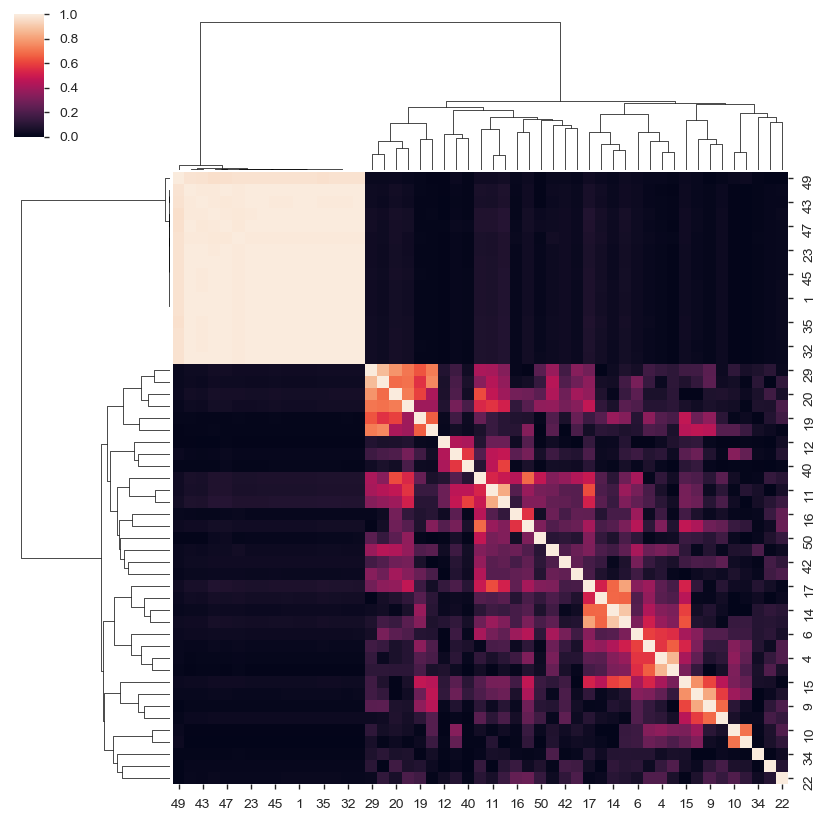

In [68]:
sns.clustermap(pearson);

In [69]:
spearman = np.absolute(counties_df[census_columns].corr(method='spearman').values)

In [70]:
spearman_raw = counties_df[census_columns].corr(method='spearman').values

In [71]:
row_linkage = hierarchy.linkage(
    distance.pdist(spearman), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(spearman.T), method='average')

In [72]:
cluster_array = hierarchy.fcluster(row_linkage, 6, criterion='maxclust')
cluster_array

array([1, 1, 2, 1, 5, 5, 2, 6, 4, 4, 6, 2, 4, 4, 4, 4, 4, 4, 4, 3, 3, 1,
       6, 1, 4, 2, 3, 1, 5, 3, 3, 3, 1, 1, 6, 1, 1, 2, 2, 2, 6, 2, 2, 1,
       2, 1, 2, 1, 1, 6, 1], dtype=int32)

In [73]:
# ('RHI825214', 'White alone, not Hispanic or Latino, percent, 2014')
# ('EDU685213', "Bachelor's degree or higher, percent of persons age 25+, 2009-2013")
# ('HSG495213', 'Median value of owner-occupied housing units, 2009-2013')
# ('HSD410213', 'Households, 2009-2013')
# ('INC110213', 'Median household income, 2009-2013')

clusters = defaultdict(list)
for index, item in enumerate(cluster_array):
    clusters[item].append(index)
    
for item in clusters:
    print(f'cluster: {item}  indices: {clusters[item]}')
    for index in clusters[item]:
        print(census_desc_list[index])
    print()

cluster: 1  indices: [0, 1, 3, 21, 23, 27, 32, 33, 35, 36, 43, 45, 47, 48, 50]
('PST045214', 'Population, 2014 estimate')
('PST040210', 'Population, 2010 (April 1) estimates base')
('POP010210', 'Population, 2010')
('VET605213', 'Veterans, 2009-2013')
('HSG010214', 'Housing units, 2014')
('HSD410213', 'Households, 2009-2013')
('BZA010213', 'Private nonfarm establishments, 2013')
('BZA110213', 'Private nonfarm employment,  2013')
('NES010213', 'Nonemployer establishments, 2013')
('SBO001207', 'Total number of firms, 2007')
('MAN450207', 'Manufacturers shipments, 2007 ($1,000)')
('RTN130207', 'Retail sales, 2007 ($1,000)')
('AFN120207', 'Accommodation and food services sales, 2007 ($1,000)')
('BPS030214', 'Building permits, 2014')
('POP060210', 'Population per square mile, 2010')

cluster: 2  indices: [2, 6, 11, 25, 37, 38, 39, 41, 42, 44, 46]
('PST120214', 'Population, percent change - April 1, 2010 to July 1, 2014')
('AGE775214', 'Persons 65 years and over, percent, 2014')
('RHI425214'

In [74]:
top_from_each_cluster = []
top_two_from_each_cluster = []
for cluster_num, cluster in enumerate(clusters):
    print(f'cluster num: {cluster_num} cluster: {clusters[cluster]}')
    
    model = LogisticRegression(solver='lbfgs', max_iter=1000)

    rfe = RFE(model, 1)
    fit = rfe.fit(X_resampled[:, clusters[cluster]], y_resampled)
    print(f'Feature Ranking: {fit.ranking_}')
    
    feature_cols = []
    for index, item in enumerate(fit.ranking_):
        original_index = clusters[cluster][index]
        if item == 1:
            feature_cols.append(original_index)
            print(census_desc_list[original_index])
            top_from_each_cluster.append(census_columns[original_index])
            top_two_from_each_cluster.append(census_columns[original_index])
        elif item == 2:
            top_two_from_each_cluster.append(census_columns[original_index])
            
    y_pred = rfe.estimator_.predict(X_test[:,feature_cols])
    y_pred_prob = rfe.estimator_.predict_proba(X_test[:,feature_cols])
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",metrics.f1_score(y_test, y_pred))    
    print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))

    print()

cluster num: 0 cluster: [0, 1, 3, 21, 23, 27, 32, 33, 35, 36, 43, 45, 47, 48, 50]
Feature Ranking: [12  4  5  3  9 13  7  6 15 10 14  8  2 11  1]
('POP060210', 'Population per square mile, 2010')
Accuracy: 0.8314785373608903
F1: 0.46464646464646464
auc:  0.6915504050405039

cluster num: 1 cluster: [2, 6, 11, 25, 37, 38, 39, 41, 42, 44, 46]
Feature Ranking: [ 5 10  4  1  2  6  7  3  8  9 11]
('HSG096213', 'Housing units in multi-unit structures, percent, 2009-2013')
Accuracy: 0.7742448330683624
F1: 0.4964539007092199
auc:  0.8107373237323733

cluster num: 2 cluster: [4, 5, 28]
Feature Ranking: [1 2 3]
('AGE135214', 'Persons under 5 years, percent, 2014')
Accuracy: 0.5786963434022258
F1: 0.3291139240506329
auc:  0.5939468946894689

cluster num: 3 cluster: [7, 10, 22, 34, 40, 49]
Feature Ranking: [2 3 4 6 1 5]
('SBO515207', 'Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007')
Accuracy: 0.8569157392686805
F1: 0.2105263157894737
auc:  0.5584214671467147

cluster num: 4 

In [75]:
top_from_each_cluster

['POP060210', 'HSG096213', 'AGE135214', 'SBO515207', 'RHI125214', 'HSG495213']

<Figure size 1000x1000 with 0 Axes>

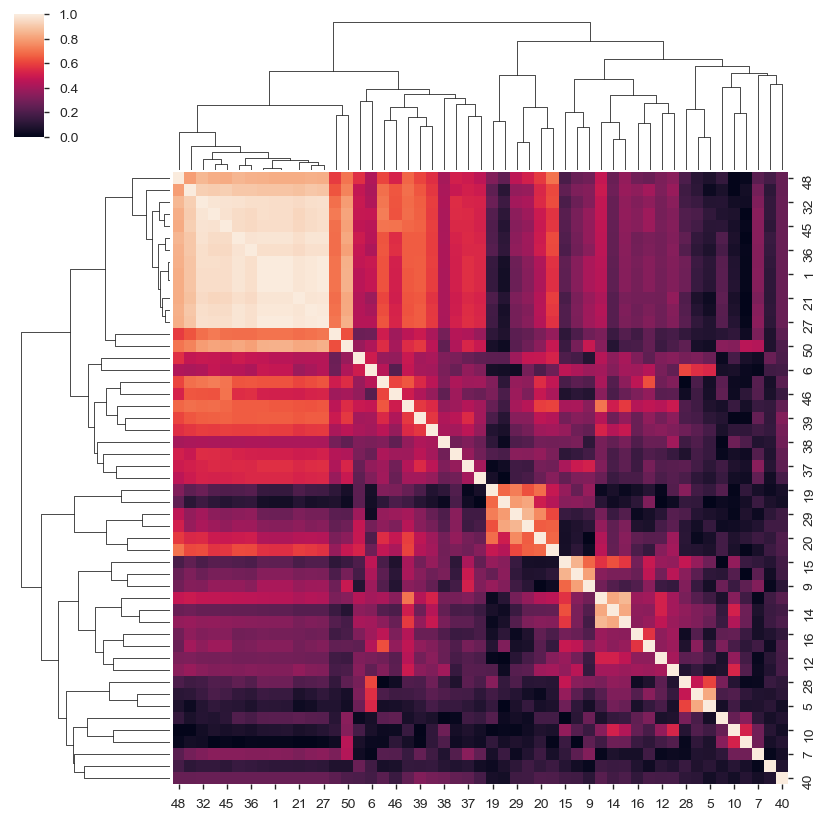

In [76]:
plt.figure(figsize=(10,10))
sns.clustermap(spearman);

In [77]:
pearson_df = pd.DataFrame(pearson, columns=census_columns, index=census_desc_list)

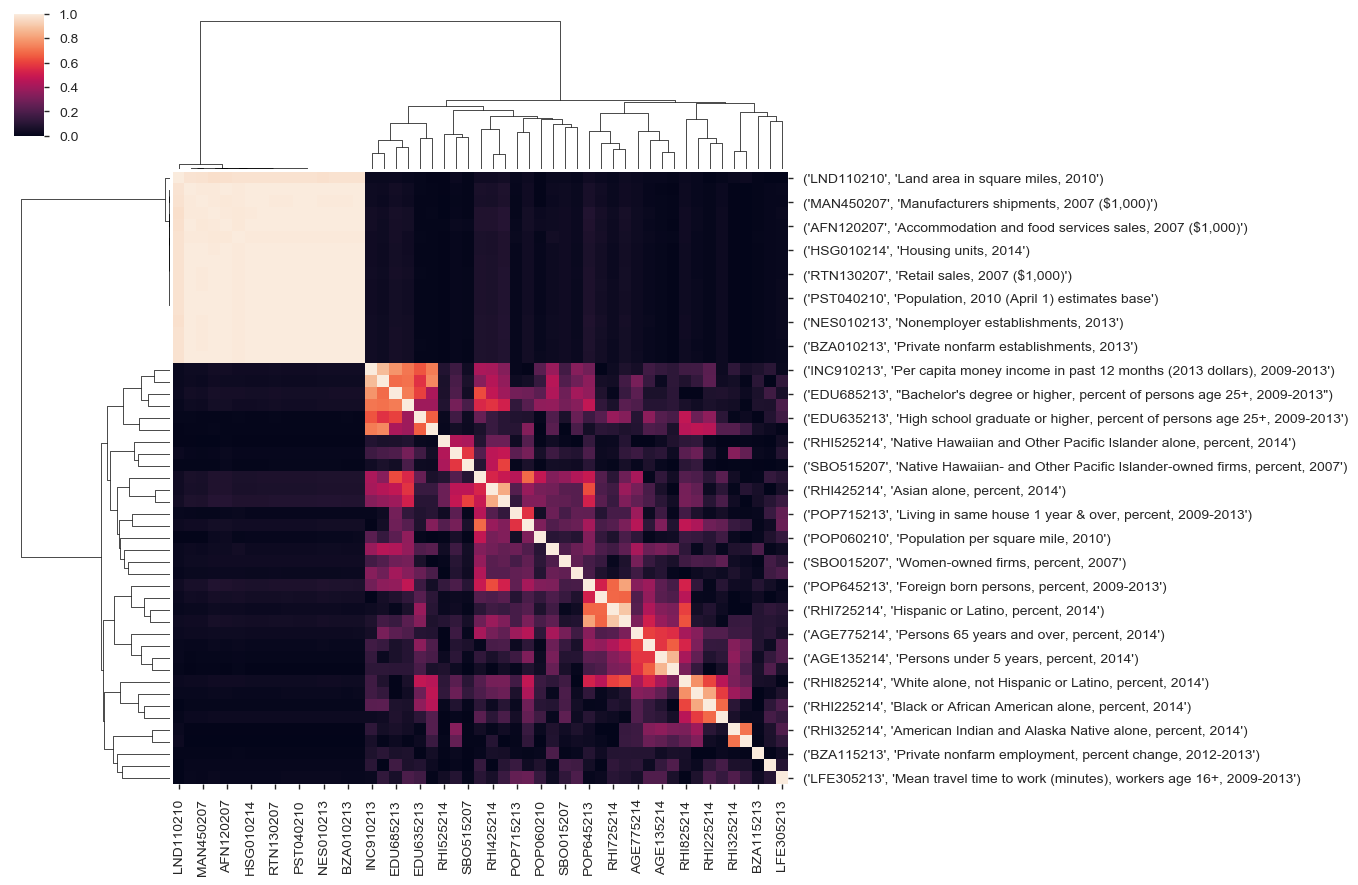

In [78]:
sns.clustermap(pearson_df);

In [79]:
#spearman_df = pd.DataFrame(spearman, columns=census_columns, index=census_desc_list)
#spearman_df = pd.DataFrame(spearman, columns=census_columns, index=census_columns)
spearman_df = pd.DataFrame(spearman)

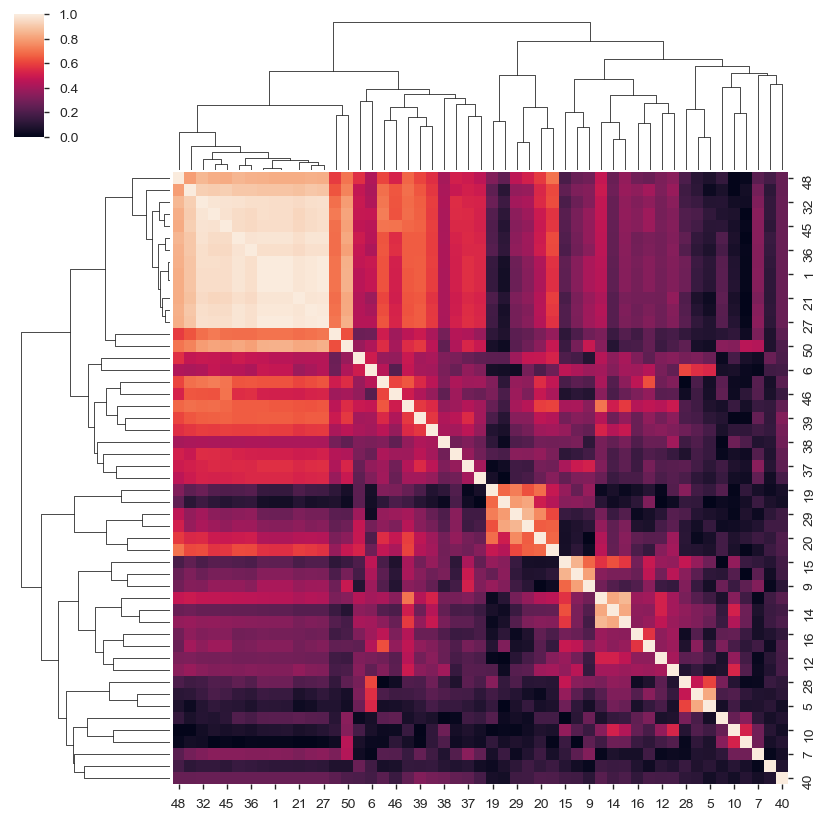

In [80]:
sns_map = sns.clustermap(spearman_df);

In [81]:
sns_map.savefig("spearman.png")

In [82]:
gen_2016_counties['winner'] = np.where(gen_2016_counties['dem_win'] == 1, 'dem', 'rep')

In [83]:
def bokeh_plot(x_factor, y_factor, logx=False, logy=False):
    scatterPlot = figure(plot_width=700, plot_height=700)
    if logx and logy:
        scatterPlot = figure(plot_width=700, plot_height=700, x_axis_type="log", y_axis_type="log")
    elif logx:
        scatterPlot = figure(plot_width=700, plot_height=700, x_axis_type="log")
    elif logy:
        scatterPlot = figure(plot_width=700, plot_height=700, y_axis_type="log")

    color_mapper = CategoricalColorMapper(factors = ["rep", "dem"],
                                         palette=['#AA2222', '#2266AA']) 
    scatterPlot.circle(x=x_factor, y=y_factor, 
                       source=gen_2016_counties, legend='winner', size=10, fill_alpha=0.1,
                       color={
                           'field': 'winner',
                           'transform': color_mapper
                       })

    scatterPlot.xaxis.axis_label = x_factor
    scatterPlot.yaxis.axis_label = y_factor

    scatterPlot.legend.location = 'bottom_right'
    scatterPlot.legend.background_fill_color = '#f9e9b6'

    tooltips = [
        ('State', '@state_abbr'),
        ('County', '@county_name'),
        ('2014 pop', '@PST045214'),
        ('Total votes', '@total_votes'),
        ('Pct repub', '@per_gop'),
        ('Pct dem', '@per_dem') 
    ]

    hover = HoverTool(tooltips=tooltips)
    scatterPlot.add_tools(hover)

    show(scatterPlot)    

In [84]:
bokeh_plot('PST045214', 'INC110213', logx=True, logy=True)

In [85]:
bokeh_plot('per_gop', 'RHI825214')

In [86]:
bokeh_plot('RHI825214', 'per_gop')

In [87]:
bokeh_plot('SBO515207', 'per_gop', logx=True)

In [88]:
bokeh_plot('EDU685213', 'INC110213')

In [89]:
rep_wins = gen_2016_counties[gen_2016_counties['dem_win'] == 0]
dem_wins = gen_2016_counties[gen_2016_counties['dem_win'] == 1]

In [90]:
# census_subset = census_columns[::5]
top_from_each_cluster.append('winner')
red_blue = {'rep' : 'red', 'dem' : 'blue'}

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



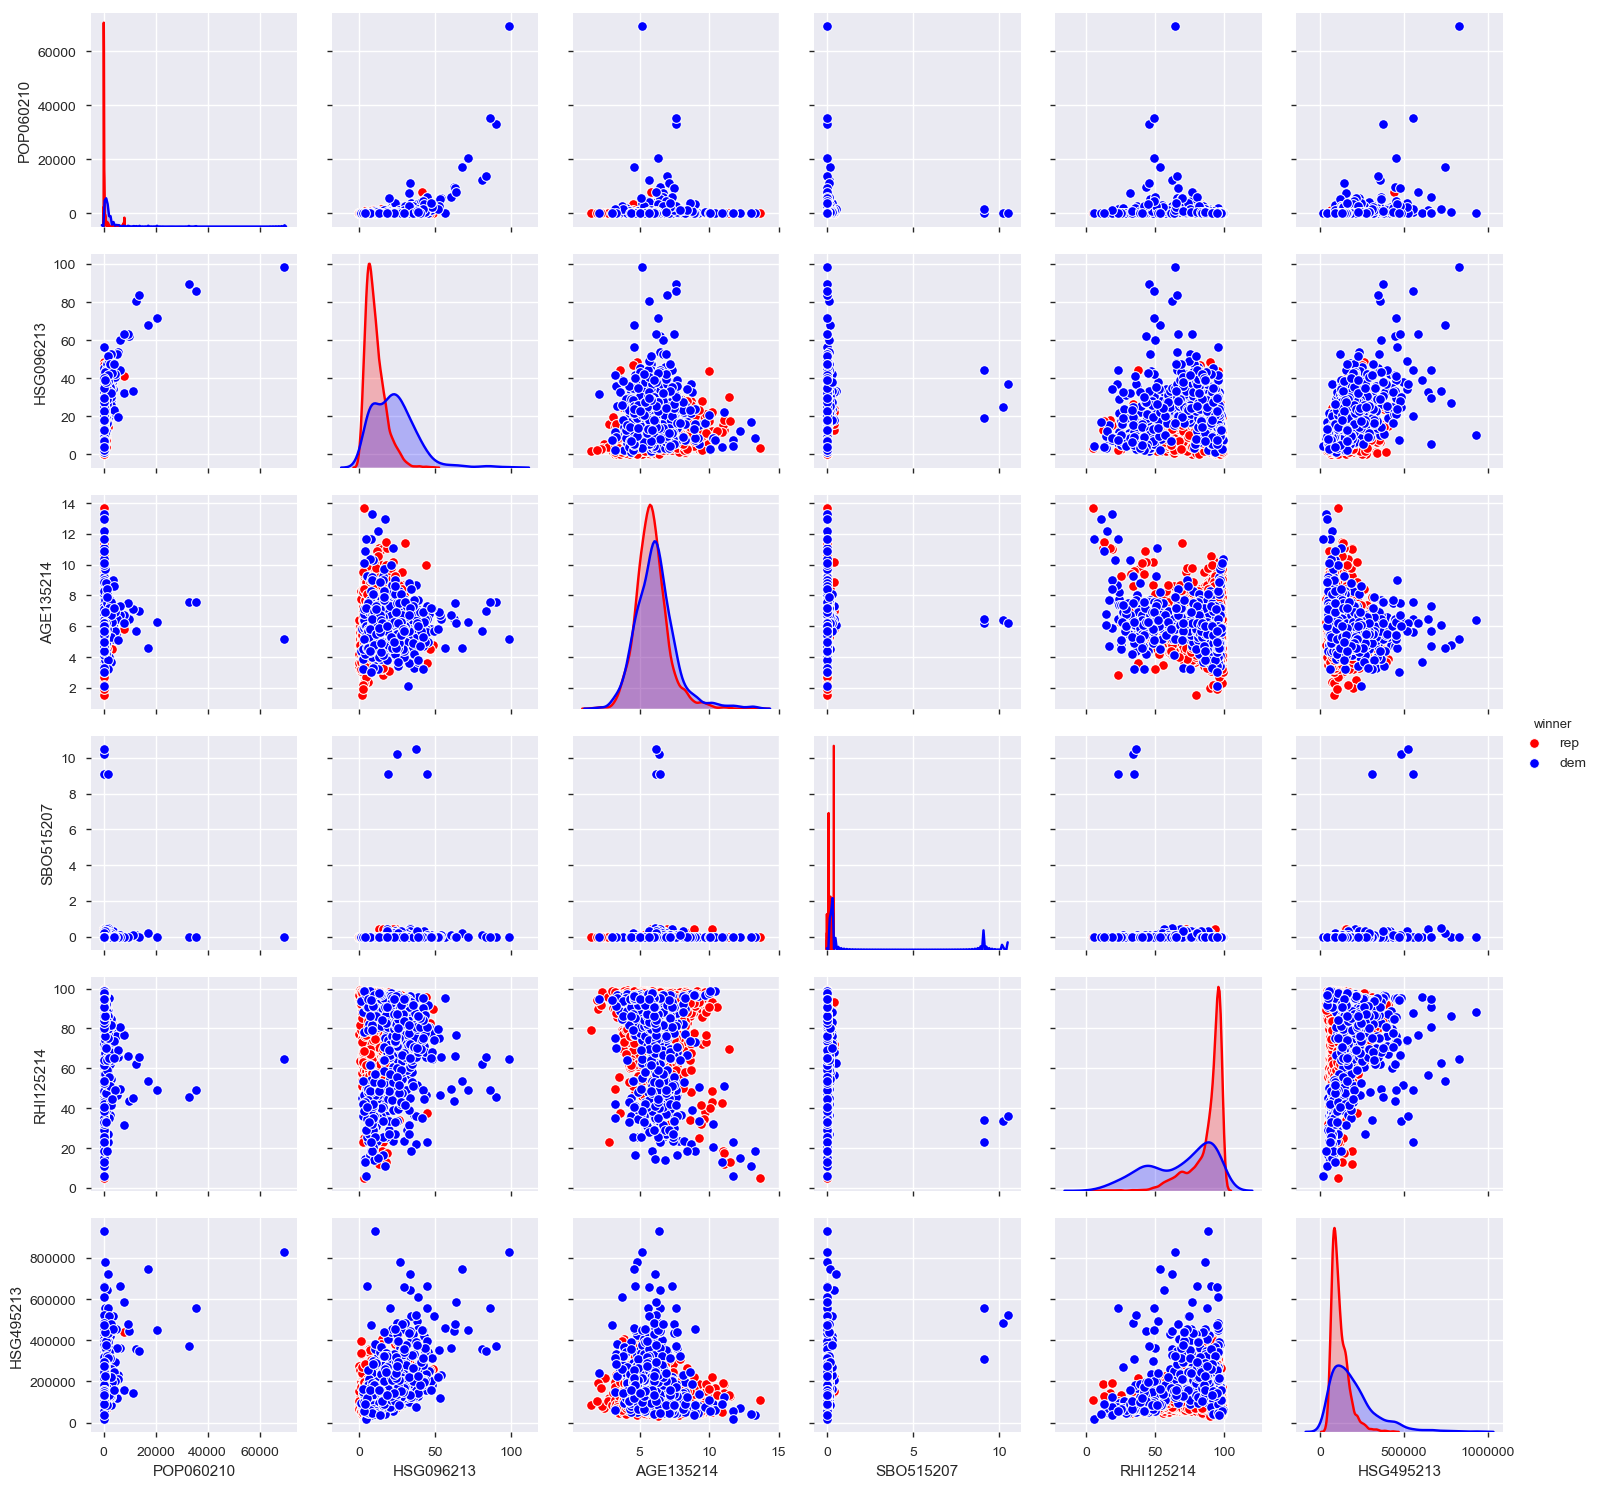

In [91]:
sns.pairplot(data=gen_2016_counties[top_from_each_cluster], hue='winner', palette=red_blue);


In [92]:
top_from_each_cluster = top_from_each_cluster[:-1] # remove 'winner' tag
print(top_from_each_cluster)

['POP060210', 'HSG096213', 'AGE135214', 'SBO515207', 'RHI125214', 'HSG495213']


In [93]:
#columns_to_use = top_two_from_each_cluster
#columns_to_use = top_from_each_cluster
columns_to_use = top_ten_features_names

In [94]:
def get_top_interaction(columns_to_use, num_to_select):
    indices_to_use = col_list_to_index_list(columns_to_use)
    X_smaller = X_resampled[:, indices_to_use]

    poly = PolynomialFeatures(degree=2).fit(X_smaller)
    poly_names = poly.get_feature_names(input_features=columns_to_use)

    X_smaller_poly = poly.transform(X_smaller)
    X_smaller_test = X_test[:, indices_to_use] 
    X_test_poly = poly.transform(X_smaller_test)

    model = LogisticRegression(solver='lbfgs', max_iter=1000)

    rfe = RFE(model, num_to_select)
    fit = rfe.fit(X_smaller_poly, y_resampled)
    print(f'Num Features: {fit.n_features_}')

    for index, item in enumerate(fit.ranking_):
        if item == 1:
            print(f'{index} :  {poly.powers_[index]} : {poly_names[index]}')

    # modified for poly_features ...
    feature_cols = []
    for index, item in enumerate(fit.ranking_):
         if item == 1:
                feature_cols.append(index)

    feature_cols
    
    y_pred = rfe.estimator_.predict(X_smaller_poly[:,feature_cols])
    y_pred_prob = rfe.estimator_.predict_proba(X_smaller_poly[:,feature_cols])

    print("Train")
    print("Accuracy:",metrics.accuracy_score(y_resampled, y_pred))
    print("F1:",metrics.f1_score(y_resampled, y_pred))
    print("auc: ",metrics.roc_auc_score(y_resampled, y_pred_prob[:,1]))
    
    y_pred = rfe.estimator_.predict(X_test_poly[:,feature_cols])
    y_pred_prob = rfe.estimator_.predict_proba(X_test_poly[:,feature_cols])
    
    print("Test")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",metrics.f1_score(y_test, y_pred))
    print("auc: ",metrics.roc_auc_score(y_test, y_pred_prob[:,1]))


In [95]:
get_top_interaction(top_ten_features_names, 8)

Num Features: 8
1 :  [1 0 0 0 0 0 0 0 0 0] : RHI525214
2 :  [0 1 0 0 0 0 0 0 0 0] : RHI825214
4 :  [0 0 0 1 0 0 0 0 0 0] : EDU685213
6 :  [0 0 0 0 0 1 0 0 0 0] : HSG495213
7 :  [0 0 0 0 0 0 1 0 0 0] : HSD410213
8 :  [0 0 0 0 0 0 0 1 0 0] : INC110213
9 :  [0 0 0 0 0 0 0 0 1 0] : NES010213
16 :  [1 0 0 0 0 1 0 0 0 0] : RHI525214 HSG495213
Train
Accuracy: 0.888758231420508
F1: 0.8891492852120928
auc:  0.9544120236926853
Test
Accuracy: 0.8807631160572337
F1: 0.7035573122529644
auc:  0.9460883588358835


In [96]:
get_top_interaction(top_five_features_names, 8)

Num Features: 8
1 :  [1 0 0 0 0] : RHI825214
2 :  [0 1 0 0 0] : EDU685213
3 :  [0 0 1 0 0] : HSG495213
4 :  [0 0 0 1 0] : HSD410213
5 :  [0 0 0 0 1] : INC110213
6 :  [2 0 0 0 0] : RHI825214^2
7 :  [1 1 0 0 0] : RHI825214 EDU685213
16 :  [0 0 1 1 0] : HSG495213 HSD410213
Train
Accuracy: 0.9021636876763875
F1: 0.9031206334420121
auc:  0.9603270089710425
Test
Accuracy: 0.8998410174880763
F1: 0.7407407407407408
auc:  0.9573769876987699


In [97]:
get_top_interaction(top_from_each_cluster, 8)

Num Features: 8
1 :  [1 0 0 0 0 0] : POP060210
2 :  [0 1 0 0 0 0] : HSG096213
5 :  [0 0 0 0 1 0] : RHI125214
6 :  [0 0 0 0 0 1] : HSG495213
8 :  [1 1 0 0 0 0] : POP060210 HSG096213
11 :  [1 0 0 0 1 0] : POP060210 RHI125214
12 :  [1 0 0 0 0 1] : POP060210 HSG495213
25 :  [0 0 0 0 2 0] : RHI125214^2
Train
Accuracy: 0.8784101599247413
F1: 0.8757510213890891
auc:  0.9316970200067436
Test
Accuracy: 0.8600953895071543
F1: 0.6363636363636364
auc:  0.8686056105610562


In [98]:
get_top_interaction(top_two_from_each_cluster, 8)

Num Features: 8
2 :  [0 1 0 0 0 0 0 0 0 0 0 0] : POP060210
3 :  [0 0 1 0 0 0 0 0 0 0 0 0] : HSG096213
9 :  [0 0 0 0 0 0 0 0 1 0 0 0] : RHI125214
11 :  [0 0 0 0 0 0 0 0 0 0 1 0] : HSG495213
32 :  [0 1 0 0 0 0 0 0 1 0 0 0] : POP060210 RHI125214
80 :  [0 0 0 0 0 0 0 1 0 0 0 1] : SBO515207 PVY020213
81 :  [0 0 0 0 0 0 0 0 2 0 0 0] : RHI125214^2
82 :  [0 0 0 0 0 0 0 0 1 1 0 0] : RHI125214 POP815213
Train
Accuracy: 0.889934148635936
F1: 0.8879310344827587
auc:  0.9583663357136347
Test
Accuracy: 0.8744038155802861
F1: 0.6748971193415638
auc:  0.9229672967296729
